In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
import os
os.getcwd()
df = pd.read_csv('summary.csv')

In [3]:
df.head()

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,pa_approved,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday
0,1,1.0,1,417380,A,75.0,0,1.0,1.0,0.0,1.0,2017-01-01,2017,1,1,1,0,0,1
1,2,NaN,1,999001,A,NaN,1,NaN,NaN,NaN,NaN,2017-01-01,2017,1,1,1,0,0,1
2,3,2.0,1,417740,A,76.0,0,1.0,0.0,0.0,1.0,2017-01-01,2017,1,1,1,0,0,1
3,4,NaN,1,999001,A,NaN,1,NaN,NaN,NaN,NaN,2017-01-01,2017,1,1,1,0,0,1
4,5,NaN,1,417740,A,NaN,1,NaN,NaN,NaN,NaN,2017-01-01,2017,1,1,1,0,0,1


In [11]:
#insert week columns
df["week"] = df["date_val"].apply(lambda x: datetime. strptime(x,'%Y-%m-%d').strftime("%W"))

In [29]:
df_filt = df.dropna(subset=["pa_approved"])

provider = df['bin'].unique()
drug = df['drug'].unique()
year = df['calendar_year'].unique()
week = df["week"].unique()

tdf = df_filt[["calendar_year", "calendar_month", "week"]].drop_duplicates()
tdf['year-month'] = tdf["calendar_year"].map(str)+'-'+tdf['calendar_month'].map(str)
tdf = tdf.set_index(["calendar_year", "week"])
tdf["volume"] = 0

for j in year:
    df_cal = df_filt[df_filt['calendar_year']==j]
    for i in week:
        PA_requests = len(df_cal[df_cal['week']==i])
        if PA_requests != 0:
            tdf.loc[(j, i), "volume"] = PA_requests

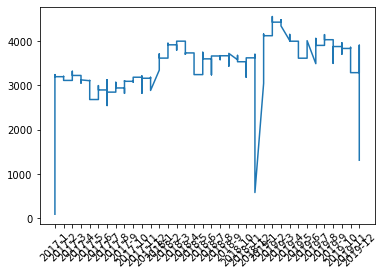

In [36]:
plt.plot(tdf["year-month"], tdf["volume"])
plt.xticks(rotation = 45)
plt.show()

In [39]:
tdf = tdf.reset_index(drop=True)

           year-month  volume
year-month                   
2017-01-01 2017-01-01      94
2017-01-01 2017-01-01    3243
2017-01-01 2017-01-01    3129
2017-01-01 2017-01-01    3106
2017-01-01 2017-01-01    3135


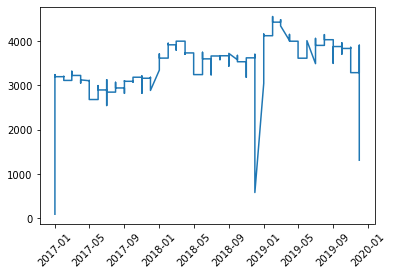

In [40]:
date = pd.Series([datetime. strptime(i,'%Y-%m') for i in tdf["year-month"]])
tdf_n = pd.concat([date, tdf["volume"]], axis=1)
tdf_n = tdf_n.rename(columns = {0:"year-month"})
tdf_n.index = tdf_n["year-month"]
print(tdf_n.head())
plt.plot(tdf_n["year-month"], tdf_n["volume"])
plt.xticks(rotation = 45)
plt.show()

In [45]:
tdf_n[tdf_n["volume"]<2000] #note decreased pa volume

,year-month,volume
year-month,,
2017-01-01,2017-01-01,94
2018-12-01,2018-12-01,584
2019-12-01,2019-12-01,1313


# The following analysis is based on the tutorial with  time series correction
https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051
https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

In [44]:
#do Augmented Dickey-Fuller Test(ADF) and calculate rolling statistics to see if our data are stable
def get_stationarity(timeseries):    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(rotation = 45)
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

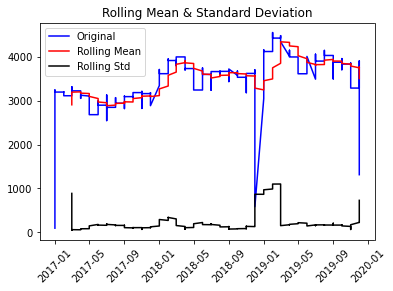

ADF Statistic: -2.4169175243703087
p-value: 0.13701838156436497
Critical Values:
	1%: -3.466598080268425
	5%: -2.8774669520682674
	10%: -2.5752604356654425


In [49]:
get_stationarity(tdf_n["volume"])
#p-value is greater than the threshold (0.05). Thus, we can conclude that the time series is not stationary.
#the rolling mean and rolling standard deviation increase with time, the time series is not stationary.

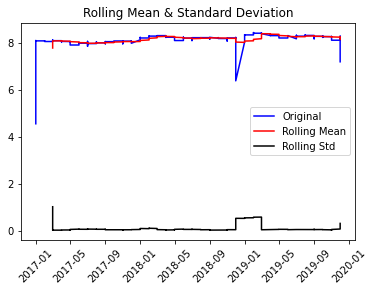

ADF Statistic: -3.691446117175514
p-value: 0.004235093648209557
Critical Values:
	1%: -3.466598080268425
	5%: -2.8774669520682674
	10%: -2.5752604356654425


In [50]:
#do a log conversion
df_log = np.log(tdf_n["volume"])
get_stationarity(df_log)

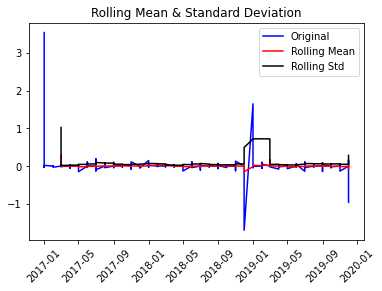

ADF Statistic: -9.534923982443724
p-value: 2.825479998478509e-16
Critical Values:
	1%: -3.4668001583460613
	5%: -2.8775552336674317
	10%: -2.5753075498128246


In [51]:
#apply time shifting, best conversion!
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

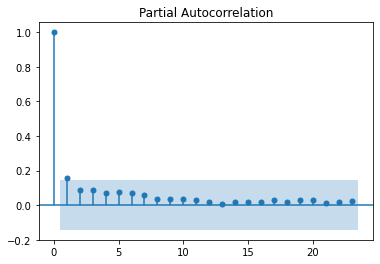

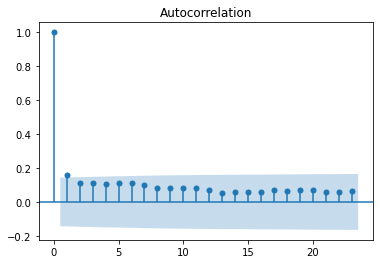

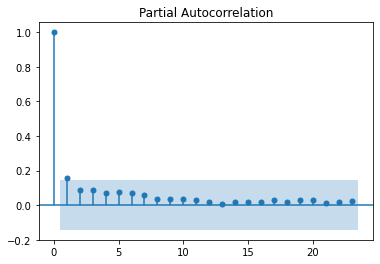

In [57]:
sm.graphics.tsa.plot_acf(df_log) #ARIMA,q
sm.graphics.tsa.plot_pacf(df_log) #ARIMA,p

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
future = 6
X = df_log_shift.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
pred_future = list(tdf_n["year-month"][size:len(X)])
for i in range(future):
    pred_future.append(pred_future[-1]+relativedelta(months=1))
history = [x for x in train]
predictions = []
# walk-forward validation
for t in range(len(pred_future)):
    model = SARIMAX(history, order=(0,1,2), seasonal_order=(0, 1, 2, 12), enforce_invertibility=False, enforce_stationarity=False)
    model_fit = model.fit(disp=-1)
    output = model_fit.forecast()
    yhat = float(output[0])
    predictions.append(yhat)
    #obs = test[t]
    #history.append(obs)
    history.append(yhat)
    #print('predicted=%f, expected=%f' % (yhat, obs))
#predictions2 = model_fil.predict


/Users/siqisun/Downloads/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


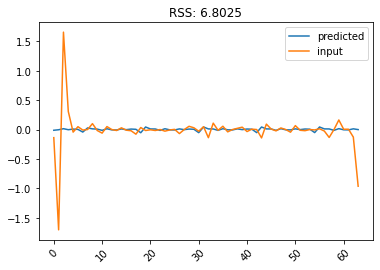

In [62]:
plt.title('RSS: %.4f'% sum((test-predictions[:(len(X)-size)])**2))
plt.plot(predictions[:(len(X)-size)], label ='predicted')
plt.plot(test, label ='input')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

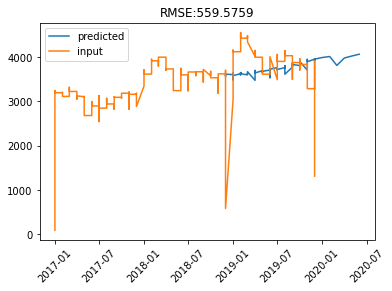

In [68]:
predictions_ARIMA_diff = pd.Series(predictions, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series([df_log[0:size][-1]]*len(pred_future)).add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.title('RMSE:%.4f' % sqrt(mean_squared_error(tdf_n["volume"][size:len(X)], predictions_ARIMA[:(len(X)-size)])))
plt.plot(pred_future, predictions_ARIMA, label ='predicted')
plt.plot(tdf_n["year-month"], tdf_n["volume"], label ='input')
plt.legend()
plt.xticks(rotation = 45)
plt.show()